<a href="https://colab.research.google.com/github/AbdalrahmanAbdelaziz/DL-Project/blob/main/XceptionNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import libraries
import numpy as np
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from google.colab import drive

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Extract the dataset from the zip file
zip_file_path = '/content/drive/My Drive/Colab Notebooks/datasets/archive.zip'
extract_path = '/content/dataset/'
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Define paths
dataPath = os.path.join(extract_path, 'car_data/')
Train = os.path.join(dataPath, 'train')
Test = os.path.join(dataPath, 'test')

Mounted at /content/drive


In [ ]:
# Define constants
input_shape = (224, 224)
batch_size = 16
img_height, img_width = 224, 224
epochs = 2
lr = 1e-4

# Apply Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)


train_generator = train_datagen.flow_from_directory(
    Train,
    target_size=input_shape,
    batch_size=batch_size,
    class_mode='categorical'
)


test_datagen = ImageDataGenerator(rescale=1.0 / 255)

test_generator = test_datagen.flow_from_directory(
    Test,
    target_size=input_shape,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


# Number of classes
num_classes = len(train_generator.class_indices)



Found 8144 images belonging to 196 classes.
Found 8041 images belonging to 196 classes.


In [ ]:
# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))

# Build the model using Xception
base_model = Xception(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Unfreeze some layers for fine-tuning
for layer in base_model.layers[-30:]:  # Fine-tune the last 30 layers
    layer.trainable = True

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
opt = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
best_model_file = '/content/drive/My Drive/Colab Notebooks/models/xception_model_1.keras'
callbacks = [
    ModelCheckpoint(best_model_file, monitor='val_accuracy', verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
]

Mounted at /content/drive
Found 8144 images belonging to 196 classes.
Found 8041 images belonging to 196 classes.
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


509/509 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.0050 - loss: 5.5436
Epoch 1: val_accuracy improved from -inf to 0.00535, saving model to best_model_xception.keras
509/509 ━━━━━━━━━━━━━━━━━━━━ 313s 503ms/step - accuracy: 0.0050 - loss: 5.5432 - val_accuracy: 0.0053 - val_loss: 5.2781 - learning_rate: 1.0000e-04
Epoch 2/30
509/509 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.0061 - loss: 5.2749
Epoch 2: val_accuracy improved from 0.00535 to 0.00572, saving model to best_model_xception.keras
509/509 ━━━━━━━━━━━━━━━━━━━━ 253s 433ms/step - accuracy: 0.0061 - loss: 5.2749 - val_accuracy: 0.0057 - val_loss: 5.2773 - learning_rate: 1.0000e-04
Epoch 3/30
509/509 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.0156 - loss: 5.2110
Epoch 3: val_accuracy improved from 0.00572 to 0.13667, saving model to best_model_xception.keras
509/509 ━━━━━━━━━━━━━━━━━━━━ 222s 432ms/step - accuracy: 0.0156 - loss: 5.2107 - val_accuracy: 0.1367 - val_loss: 4.3096 - learning_rate: 1.0000e-04
Epoch 4/3

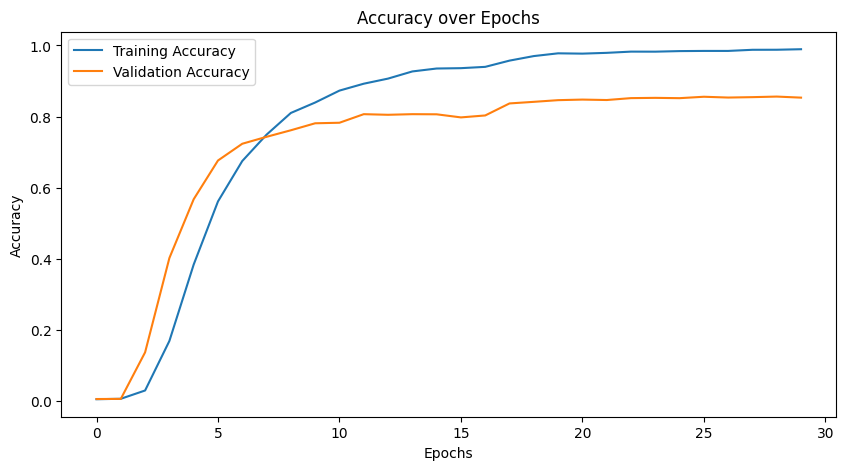

In [ ]:
# Train the model
hist = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=epochs,
    class_weight=class_weights_dict,
    callbacks=callbacks
)

In [ ]:
# Train the model
hist = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=epochs,
    class_weight=class_weights_dict,
    callbacks=callbacks
)

Epoch 1/2
509/509 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.9888 - loss: 0.0469
Epoch 1: val_accuracy improved from -inf to 0.85723, saving model to /content/drive/My Drive/Colab Notebooks/models/xception_model_1.keras
509/509 ━━━━━━━━━━━━━━━━━━━━ 289s 508ms/step - accuracy: 0.9888 - loss: 0.0469 - val_accuracy: 0.8572 - val_loss: 0.6579 - learning_rate: 1.0000e-05
Epoch 2/2
509/509 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.9886 - loss: 0.0429
Epoch 2: val_accuracy did not improve from 0.85723
509/509 ━━━━━━━━━━━━━━━━━━━━ 256s 501ms/step - accuracy: 0.9886 - loss: 0.0429 - val_accuracy: 0.8526 - val_loss: 0.6664 - learning_rate: 1.0000e-05


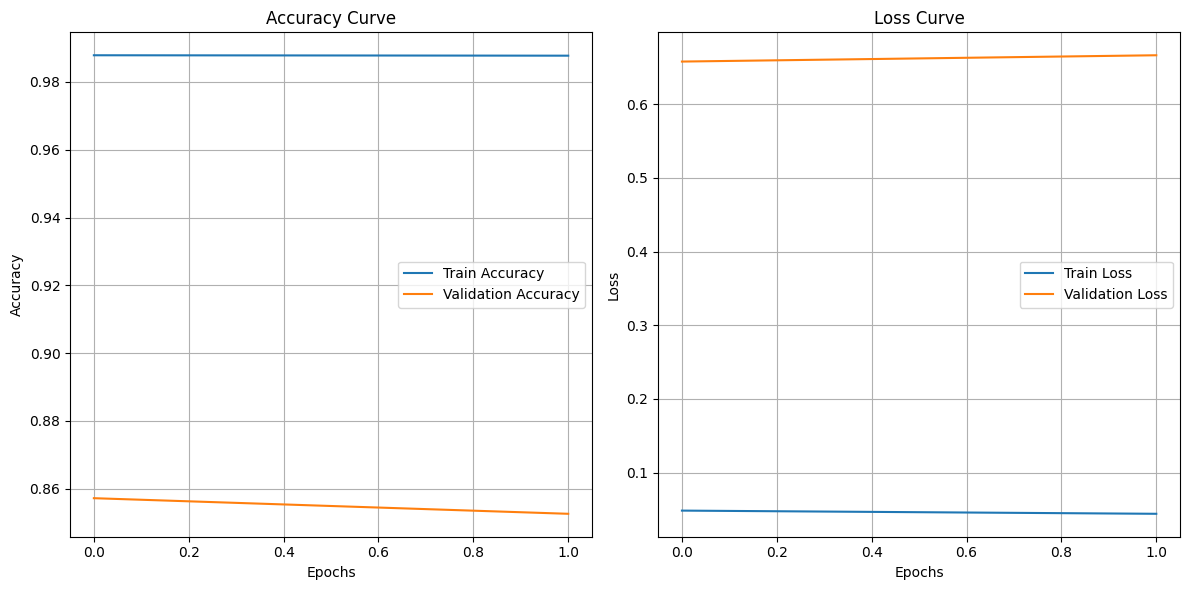

In [ ]:
# Extract training history
history = hist.history

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras.models import load_model

# Load the best saved model
model = load_model('/content/drive/My Drive/Colab Notebooks/models/xception_model_1.keras')


In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.2f}")

503/503 ━━━━━━━━━━━━━━━━━━━━ 58s 108ms/step - accuracy: 0.8309 - loss: 0.7670
Test Accuracy: 0.86


In [ ]:
# Generate classification report
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))


503/503 ━━━━━━━━━━━━━━━━━━━━ 48s 91ms/step
                                                        precision    recall  f1-score   support

                            AM General Hummer SUV 2000       0.89      0.95      0.92        44
                             Acura Integra Type R 2001       0.82      0.93      0.87        44
                                   Acura RL Sedan 2012       0.57      0.72      0.64        32
                                   Acura TL Sedan 2012       0.78      0.88      0.83        43
                                  Acura TL Type-S 2008       0.93      0.93      0.93        42
                                  Acura TSX Sedan 2012       0.93      0.70      0.80        40
                              Acura ZDX Hatchback 2012       0.89      0.82      0.85        39
              Aston Martin V8 Vantage Convertible 2012       0.67      0.69      0.68        45
                    Aston Martin V8 Vantage Coupe 2012       0.71      0.61      0.66       

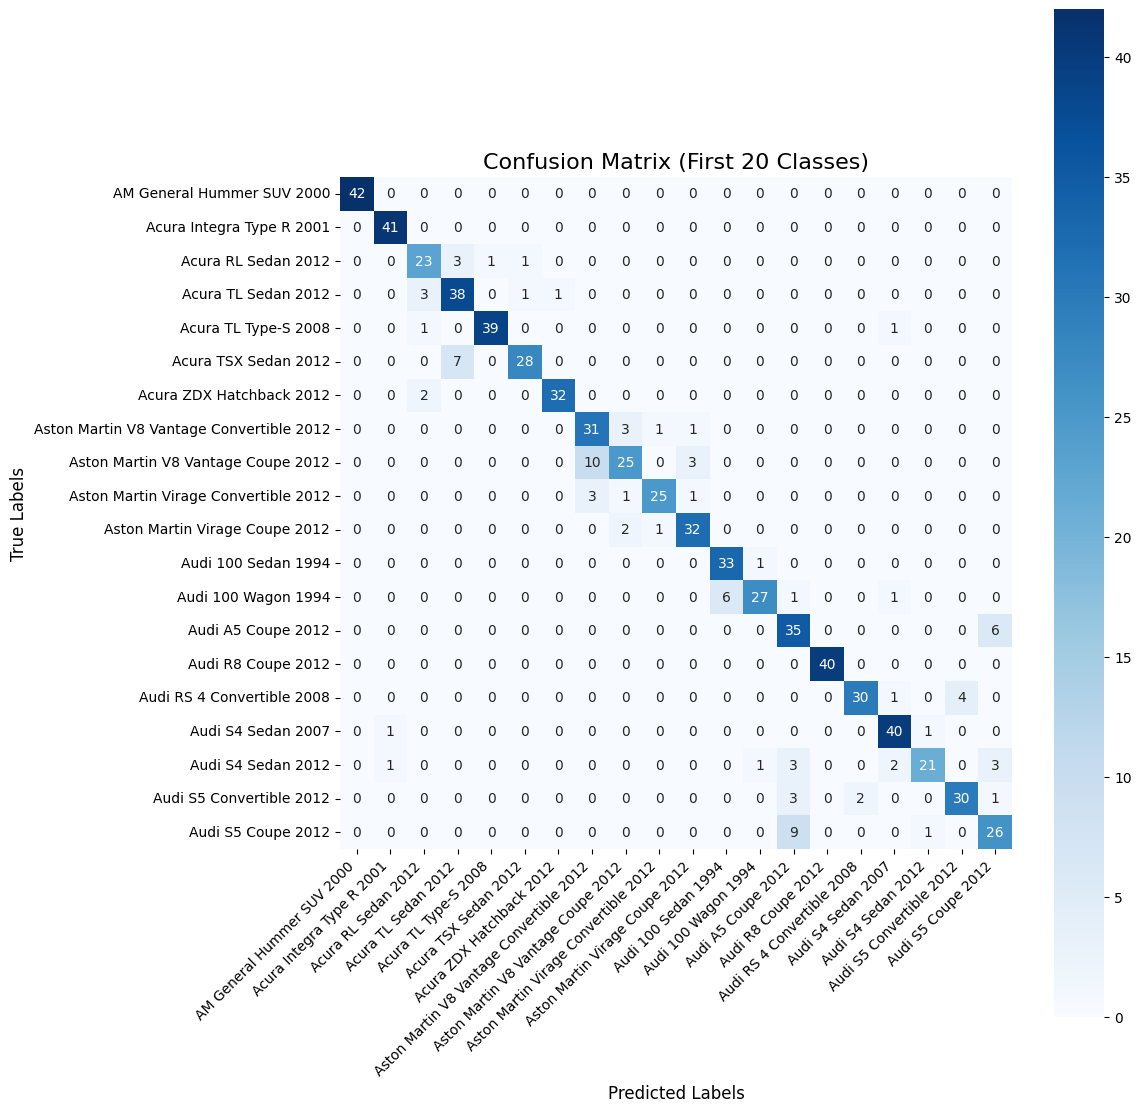

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_true (true labels) and y_pred (predicted labels) are already available

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Get class labels (mapping of class indices to class names)
class_labels = list(test_generator.class_indices.keys())

# Plot confusion matrix (only display the first 20 classes if needed)
num_classes_to_display = 20
cm_subset = cm[:num_classes_to_display, :num_classes_to_display]
class_labels_subset = class_labels[:num_classes_to_display]

# Plot the confusion matrix for the first 20 classes
plt.figure(figsize=(12, 12))
sns.heatmap(
    cm_subset,
    annot=True,            # Annotate cells with counts
    fmt='d',               # Display as integers
    cmap='Blues',          # Colormap style
    xticklabels=class_labels_subset,   # X-axis labels
    yticklabels=class_labels_subset,   # Y-axis labels
    cbar=True,             # Include color bar
    square=True            # Square-shaped heatmap
)

# Set titles and labels
plt.title("Confusion Matrix (First 20 Classes)", fontsize=16)
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()  # Adjust layout for better fit
plt.show()


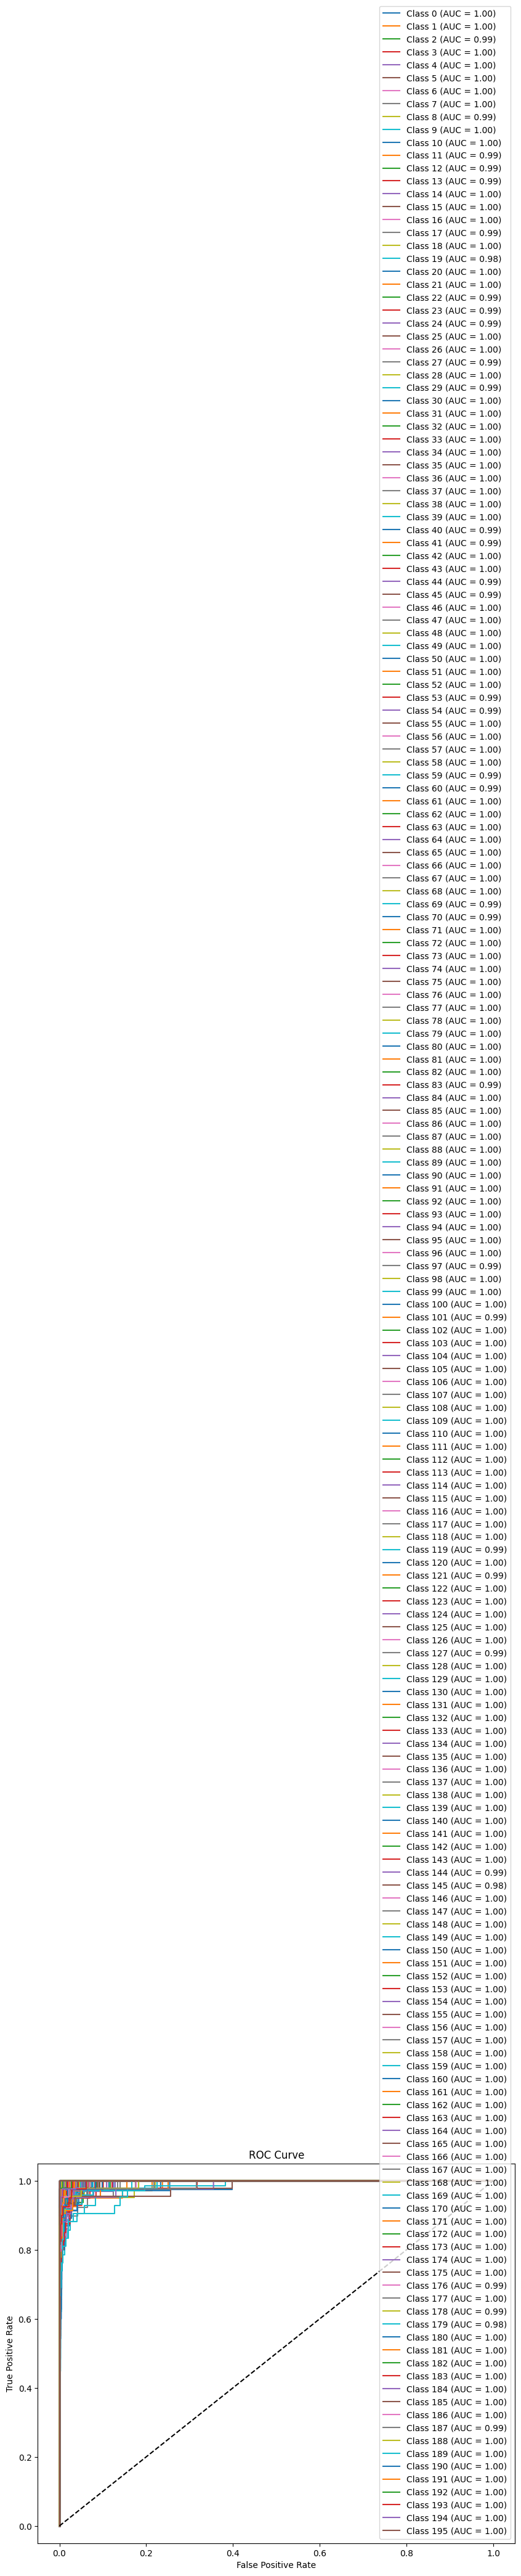

In [ ]:
# Plot ROC-AUC curve
fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(to_categorical(y_true, num_classes)[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)  # Convert to a NumPy array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Rescale
    return img_array



In [ ]:
# Provide the path to the image you want to test
test_image_path = '/content/drive/My Drive/Colab Notebooks/models/jj.jpeg'  # Replace with an actual image path

# Preprocess the image
preprocessed_image = preprocess_image(test_image_path)

# Predict the class
predictions = model.predict(preprocessed_image)
predicted_class = np.argmax(predictions)  # Get the index of the class with the highest probability

# Map the index to the class label
class_labels = list(train_generator.class_indices.keys())
print(f"Predicted Class: {class_labels[predicted_class]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted Class: Nissan Juke Hatchback 2012


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


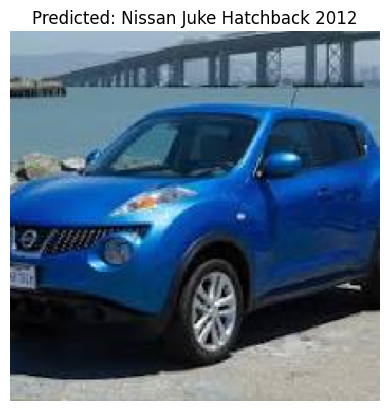

In [ ]:
import matplotlib.pyplot as plt

# Load and preprocess the image
img = image.load_img(test_image_path, target_size=(img_height, img_width))
preprocessed_image = preprocess_image(test_image_path)

# Predict
predictions = model.predict(preprocessed_image)
predicted_class = np.argmax(predictions)

# Display the image and prediction
plt.imshow(img)
plt.title(f"Predicted: {class_labels[predicted_class]}")
plt.axis('off')
plt.show()
